# Implementation LSTM model for Forecasting

In [1]:
import time
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## DATA INGESTION

In [3]:
# Stock Input
symbol = input("Input simbol saham (e.g 'BBRI.JK'): ")
start_date = date(2023, 1, 1)
end_date = date(2024, 1, 1)

data = yf.download(symbol, start=start_date, end=end_date)

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,4910.0,4920.0,4820.0,4870.0,4349.535156,100200100
2023-01-03,4830.0,4900.0,4830.0,4850.0,4331.672852,95136500
2023-01-04,4850.0,4850.0,4770.0,4770.0,4260.222656,188071000
2023-01-05,4750.0,4760.0,4570.0,4640.0,4144.115723,292142000
2023-01-06,4550.0,4640.0,4550.0,4620.0,4126.253418,175932000


In [6]:
data.reset_index(inplace=True)

# FEATURE input from user
input_feat = input("Input feature yang akan digunakan (e.g: Open, High, Low, Close, Adj Close, Volume): ")
data = data[["Date", input_feat]]
print(data.shape)
data

(239, 2)


,Date,Close
0,2023-01-02,4870.0
1,2023-01-03,4850.0
2,2023-01-04,4770.0
3,2023-01-05,4640.0
4,2023-01-06,4620.0
...,...,...
234,2023-12-21,5575.0
235,2023-12-22,5675.0
236,2023-12-27,5625.0
237,2023-12-28,5725.0


## DATA PROCESSING

In [7]:
# scaling feature
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

In [8]:
# split data into data training and data testing
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

In [9]:
# Create Sequence for splitting the data into different time series to train the model
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [20]:
sequence_length = 1
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [19]:
tf.random.set_seed(7)

## Modeling

In [21]:
# model LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

# Training

In [22]:
# training process
optimizer = Adam(learning_rate=0.005)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
model_final = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2,
                        callbacks=[ early_stopping],
                        validation_data=(X_test, y_test))

Epoch 1/100
3/3 - 5s - loss: 0.3965 - mean_absolute_error: 0.5684 - val_loss: 0.4132 - val_mean_absolute_error: 0.6232 - 5s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.3178 - mean_absolute_error: 0.4983 - val_loss: 0.2852 - val_mean_absolute_error: 0.5126 - 95ms/epoch - 32ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1948 - mean_absolute_error: 0.3727 - val_loss: 0.0984 - val_mean_absolute_error: 0.2862 - 95ms/epoch - 32ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0587 - mean_absolute_error: 0.1995 - val_loss: 0.0291 - val_mean_absolute_error: 0.1488 - 79ms/epoch - 26ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0842 - mean_absolute_error: 0.2547 - val_loss: 0.0364 - val_mean_absolute_error: 0.1697 - 87ms/epoch - 29ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0544 - mean_absolute_error: 0.1950 - val_loss: 0.0146 - val_mean_absolute_error: 0.0955 - 92ms/epoch - 31ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0425 - mean_absolute_error: 0.1784 - val_loss: 0.0449 - val_mean_absolute_error: 0.1829 - 68ms/epoch - 23ms/s

## Evaluation

In [23]:
# Returns the loss value & metrics values for the model in test mode
loss = model.evaluate(X_test, y_test)
round_loss = [round(num, 5) for num in loss]
print("Loss :", round_loss)

predict = model.predict(X_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0484
Loss : [0.00433, 0.04841]
2/2 [==============================] - 1s 5ms/step


In [24]:
print("-"*5, " Metric ","-"*5)
print('RMSE : ', round(sqrt(metrics.mean_squared_error(y_test, predict)), 5))
print('MSE  : ', round(abs(metrics.mean_squared_error(y_test, predict)), 5))
print('MAE  : ', round(metrics.mean_absolute_error(y_test, predict), 5))

-----  Metric  -----
RMSE :  0.06577
MSE  :  0.00433
MAE  :  0.04841


## Visualization

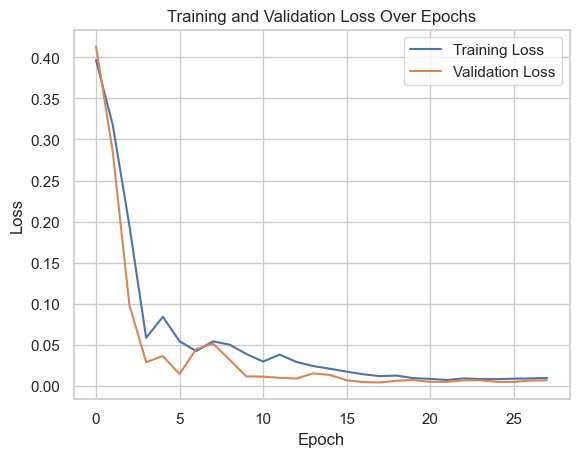

In [25]:
# Plot loss
sns.set(style="whitegrid")

sns.lineplot(x=range(len(model_final.history['loss'])), y=model_final.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(model_final.history['val_loss'])), y=model_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

## Saving Model

In [26]:
ts = int(time.time())
file_path = f"../lstm_stock/{ts}/"
model.save(filepath=file_path, save_format='tf')
print("Success saving model!")

NameError: name 'time' is not defined